In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, results as rs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

fa_max = pd.to_datetime(scs_raw['Entry Time'],dayfirst=True).max()
report_end = fa_max.ceil('H')
report_start = report_end - pd.to_timedelta(12, unit='H')

at = feat.pre_process_AT(at)
av = feat.pre_process_av(av)
fa,unmapped = feat.preprocess_faults(scs_raw)

Output,R2,feat = rs.run_single_model(at,av,fa,report_start,report_end,shift=0,weights=[1],speed=470,picker_present=0.91,availability=0.71)

Running: Function "pre_process_AT" (id=2538689606848) was called 1 times
Running: Function "pre_process_av" (id=2538689609440) was called 1 times
Running: Function "preprocess_faults" (id=2538689608000) was called 1 times
Running: Function "load_tote_lookup" (id=2538689608864) was called 1 times
Running: Function "load_module_lookup" (id=2538686700560) was called 1 times
Running: Function "load_ID_lookup" (id=2538689609584) was called 1 times
Running: Function "run_single_model" (id=2538691400608) was called 1 times
Running: Function "floor_shift_time_fa" (id=2538689608144) was called 1 times
Running: Function "create_PTT_df" (id=2538689906720) was called 1 times
Running: Function "fault_select" (id=2538689904704) was called 1 times
Running: Function "load_PTT_lookup" (id=2538689609296) was called 1 times
Running: Function "faults_aggregate" (id=2538689904992) was called 1 times
Running: Function "weight_hours" (id=2538689906144) was called 1 times
Running: Function "av_at_select" (id=

Running: Function "faults_aggregate" (id=2538689904992) was called 14 times
Running: Function "weight_hours" (id=2538689906144) was called 14 times
Running: Function "av_at_select" (id=2538689905280) was called 14 times
Running: Function "aggregate_availability" (id=2538689905568) was called 14 times
Running: Function "aggregate_totes" (id=2538689905856) was called 14 times
Running: Function "merge_av_fa_at" (id=2538689906432) was called 14 times
Running: Function "fault_select" (id=2538689904704) was called 15 times
Running: Function "load_PTT_lookup" (id=2538689609296) was called 15 times
Running: Function "faults_aggregate" (id=2538689904992) was called 15 times
Running: Function "weight_hours" (id=2538689906144) was called 15 times
Running: Function "av_at_select" (id=2538689905280) was called 15 times
Running: Function "aggregate_availability" (id=2538689905568) was called 15 times
Running: Function "aggregate_totes" (id=2538689905856) was called 15 times
Running: Function "merge_

Running: Function "fault_select" (id=2538689904704) was called 28 times
Running: Function "load_PTT_lookup" (id=2538689609296) was called 28 times
Running: Function "faults_aggregate" (id=2538689904992) was called 28 times
Running: Function "weight_hours" (id=2538689906144) was called 28 times
Running: Function "av_at_select" (id=2538689905280) was called 28 times
Running: Function "aggregate_availability" (id=2538689905568) was called 28 times
Running: Function "aggregate_totes" (id=2538689905856) was called 28 times
Running: Function "merge_av_fa_at" (id=2538689906432) was called 28 times
Running: Function "fault_select" (id=2538689904704) was called 29 times
Running: Function "load_PTT_lookup" (id=2538689609296) was called 29 times
Running: Function "faults_aggregate" (id=2538689904992) was called 29 times
Running: Function "weight_hours" (id=2538689906144) was called 29 times
Running: Function "av_at_select" (id=2538689905280) was called 29 times
Running: Function "aggregate_availa

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Running: Function "cross_validate_r2" (id=2538691338096) was called 1 times

Cross Validation Scores: 
 
        R2 Scores
1       0.478925
2       0.468071
3       0.478461
4       0.460647
5       0.499684
Mean    0.477157
STD     0.013171
                                 OLS Regression Results                                
Dep. Variable:           Availability   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              869.8
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                        0.00
Time:                        14:28:21   Log-Likelihood:                          7077.9
No. Observations:               11715   AIC:                                 -1.352e+04
Df Residuals:                   11399   BIC:                                 -1.120e+04
Df Model:                         316                 

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [9]:
at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

SyntaxError: invalid syntax (<ipython-input-9-5c738e53ba5e>, line 1)

In [4]:
at = feat.pre_process_AT(at)

AttributeError: 'int' object has no attribute 'pre_process_AT'

In [ ]:
av = feat.pre_process_av(av)

In [ ]:
fa,unmapped, end_time = feat.preprocess_faults(scs_raw)

#fa= fa[fa['timestamp']<(fa['timestamp'].max()-pd.to_timedelta(7, unit='D'))]

In [ ]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

In [ ]:
df,fa_PTT = feat.create_PTT_df(fa_floor,at,av,weights = [1])

df = feat.log_totes(df) 

In [ ]:
df

In [ ]:
df_week = df[df['timestamp']>end_time - pd.to_timedelta(14, unit='D')]

In [ ]:
X,y = md.gen_feat_var(df,target = 'Availability', features = ['Faults','Totes'])


In [ ]:
X_train, X_test, y_train, y_test = md.split(X,y,split_options = {'test_size': 0.3,
                                                                 'random_state': 42})

R2_cv,R2_OOS,Coeff = md.run_OLS(X_train = X_train,y_train = y_train,X_test = X_test,y_test=y_test, n = 30)

In [ ]:
R2_OOS

# Plotting

In [5]:
Output[Output['AREA'] == 'PTT']['ID'].value_counts()

C13PTT172    54
C08PTT082    39
C08PTT072    38
C06PTT031    28
C06PTT021    27
C10PTT111    25
C10PTT112    13
C06PTT022    12
C11PTT132    11
C11PTT122    10
Name: ID, dtype: int64

In [2]:
Total = Output[['AREA','SINGLES']].groupby('AREA').sum().reset_index()

Text(0.5, 1.0, 'SCS Lost Singles Last 12 Hours')

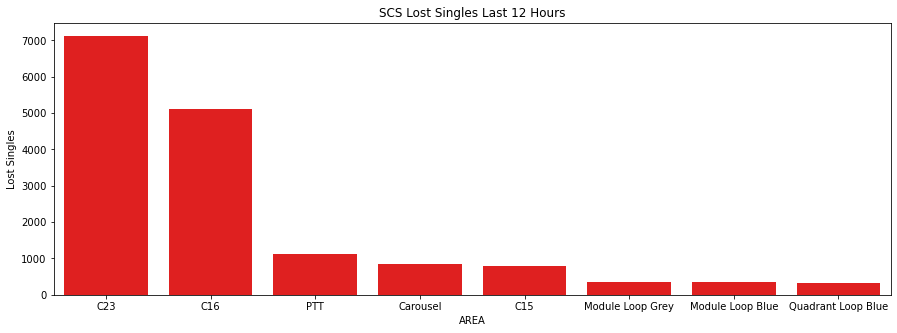

In [3]:
plt.figure(figsize=(15,5))
sns.barplot(y='SINGLES',x = 'AREA',data = Total.sort_values(by='SINGLES',ascending=False).head(10),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [ ]:
PTT081 = Output[['Asset Code','PTT081']].groupby('Asset Code').sum().reset_index()

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(y='PTT081',x = 'Asset Code',data = PTT081.sort_values(by='PTT081',ascending=False).head(5),color = 'r')
plt.ylabel('Lost Singles')
plt.title('PTT081 Lost Singles Last 12 Hours')

In [ ]:
Total_colour = Output[['BLUEGREY','SINGLES']].groupby('BLUEGREY').sum().reset_index()

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(y='SINGLES',x = 'BLUEGREY',data = Total_colour.sort_values(by='SINGLES',ascending=False),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [ ]:
Total_colour

In [ ]:
sns.lmplot(x='log_totes', y='Availability', data=df, line_kws={"color": "red"})
plt.xlim(0, 5)

In [ ]:
sns.lmplot(x='TOTES', y='Availability', data=df_week, line_kws={"color": "red"})

In [ ]:
ax = sns.regplot(x="TOTES", y="Availability", data=df_week,
x_estimator=np.mean, logx=True, line_kws={"color": "red"})
plt.ylim(0,1)

In [ ]:
sns.lmplot(x='log_totes', y='Availability', data=df_week, line_kws={"color": "red"})
plt.xlim(0, 5)

In [ ]:
Shift = [0,0,0,10,10,10,20,20,20]
Weights = [[1],[0.7,0.3],[0.7,0.2,0.1],[1],[0.7,0.3],[0.7,0.2,0.1],[1],[0.7,0.3],[0.7,0.2,0.1]]

In [ ]:
Weights[8]

In [ ]:
y

In [ ]:
at

In [ ]:
fa_floor

In [ ]:
df.drop(['Availability','Blue Tote Loss','Grey Tote Loss','timestamp'],axis=1)

In [ ]:
Outputs = {0.5:'Number One',0.4:'Number Two',-1.4:'Number 3'}

In [ ]:
 Output = Outputs[max(k for k, v in Outputs.items())]

In [ ]:
Outputs[0.456]='Numbers 4'

In [ ]:
Outputs

In [ ]:
print('Selected R2:', max(k for k, v in Outputs.items()))

In [ ]:
fa_floor = feat.floor_shift_time_fa(fa, shift=10)

df,fa_PTT = feat.create_PTT_df(fa_floor,at,av,weights=[0.7,0.2,0.1])
df = feat.log_totes(df) 
df_2week = df[df['timestamp']>end_time - pd.to_timedelta(14, unit='D')]
X,y = md.gen_feat_var(df_2week,target = 'Availability', features = ['Totes','Faults'])
X_train, X_test, y_train, y_test = md.split(X,y,split_options = {'test_size': 0.3,
                                                                    'random_state': None})

R2_cv,R2_OOS,Coeff = md.run_OLS(X_train = X_train,y_train = y_train,X_test = X_test,y_test=y_test, n = 30)

Output = rs.create_output(fa_PTT,Coeff,end_time,speed = speed, picker_present = picker_present, availability = availability)

In [ ]:
R2_OOS

In [ ]:
fa_floor

In [ ]:
print(fa.loc[fa['Area'].isnull() & fa['Desk'] == 'Z', 'Area'])

In [ ]:
fa['Area'].isnull() & fa['Desk'] == 'Z' 

In [ ]:
fa

In [ ]:
type(fa)

In [ ]:
from datetime import datetime 
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

In [ ]:
log = pd.read_excel('C:/Users/Jamie.williams/desktop/scs/Run_log.xlsx')
new_row = pd.DataFrame([['dt_string','R2_sel','feat_sel','runtime','report_start','report_end']],columns = list(log.columns))

In [ ]:
new_row

In [ ]:
import time
now = datetime.now()
time.sleep(2)
now2 = datetime.now()
now2-now

In [ ]:
'asdsad' +'asddasd'

In [ ]:
fa['timestamp'].max()

In [ ]:
max_date = pd.to_datetime(scs_raw['Entry Time'],dayfirst=True).max()

In [ ]:
max_date2 = pd.to_datetime(fa_old['Entry Time'],dayfirst=True).max()

In [ ]:
Test_time = pd.to_timedelta(48,unit='H')

In [ ]:
Test_time.days

In [ ]:
list(at.columns) == ['Module','TOTES','timestamp','Quadrant']

In [ ]:
at

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}

In [ ]:
av

In [ ]:
av.info()

In [7]:
pd.read_csv(r'cache.csv')

FileNotFoundError: [Errno 2] No such file or directory: './cache.csv'